In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# 1. Сборка единого датасета
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

# Добавляем Survived в test
test_merged = pd.merge(test, gender_submission, on='PassengerId', how='left')

# Объединяем train и test в один датафрейм
full_data = pd.concat([train, test_merged], ignore_index=True)

# Сохраняем полный датасет (опционально)
full_data.to_csv('full_titanic.csv', index=False)

print("Полный датасет создан: shape =", full_data.shape)

Полный датасет создан: shape = (1309, 12)


In [18]:
# 2. Анализ пропусков
print("\nПропущенные значения по колонкам:")
print(full_data.isnull().sum())


Пропущенные значения по колонкам:
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64



Возрастная статистика:
Общий средний возраст: 29.88
Общая медиана возраста: 28.00

Мужчины — средний: 30.59, медиана: 28.00
Женщины — средний: 28.69, медиана: 27.00


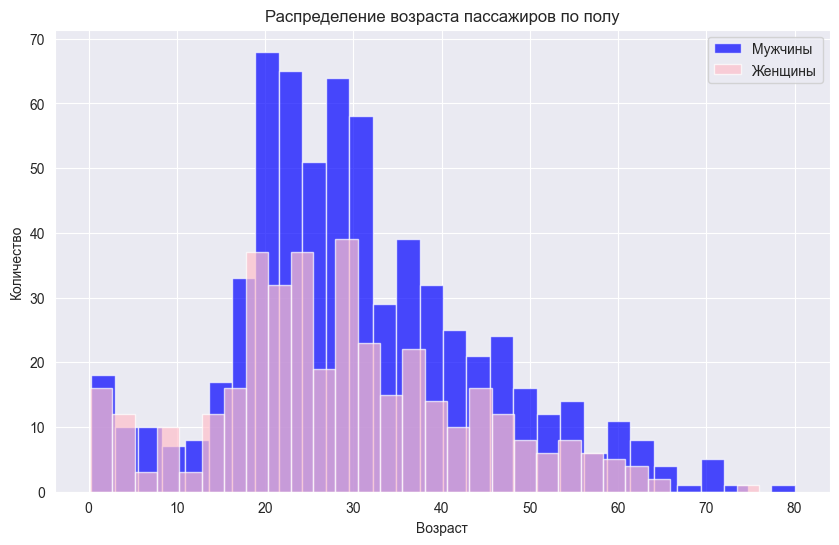

/var/folders/4c/jkygkw1s1yj6cx40mzszqyg00000gn/T/ipykernel_6617/3172508275.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_data['Age'].fillna(full_data['Age'].median(), inplace=True)


In [19]:
# 3. Анализ возраста + графики + заполнение пропусков
print("\nВозрастная статистика:")
print(f"Общий средний возраст: {full_data['Age'].mean():.2f}")
print(f"Общая медиана возраста: {full_data['Age'].median():.2f}")

print(f"\nМужчины — средний: {full_data[full_data['Sex']=='male']['Age'].mean():.2f}, медиана: {full_data[full_data['Sex']=='male']['Age'].median():.2f}")
print(f"Женщины — средний: {full_data[full_data['Sex']=='female']['Age'].mean():.2f}, медиана: {full_data[full_data['Sex']=='female']['Age'].median():.2f}")

# Графики распределения возраста по полу
plt.figure(figsize=(10, 6))
full_data[full_data['Sex']=='male']['Age'].hist(alpha=0.7, bins=30, label='Мужчины', color='blue')
full_data[full_data['Sex']=='female']['Age'].hist(alpha=0.7, bins=30, label='Женщины', color='pink')
plt.title('Распределение возраста пассажиров по полу')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend()
plt.show()

# Заполнение пропусков в Age медианой по группе Pclass + Sex
full_data['Age'] = full_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Если остались пропуски (редко), заполняем общей медианой
full_data['Age'].fillna(full_data['Age'].median(), inplace=True)

In [20]:
# 4. Категоризация возраста
bins = [0, 18, 60, full_data['Age'].max() + 1]
labels = ['дети', 'средний возраст', 'старшие']
full_data['Age_Cat'] = pd.cut(full_data['Age'], bins=bins, labels=labels, include_lowest=True)


Статистика по тарифам (Fare):
count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64


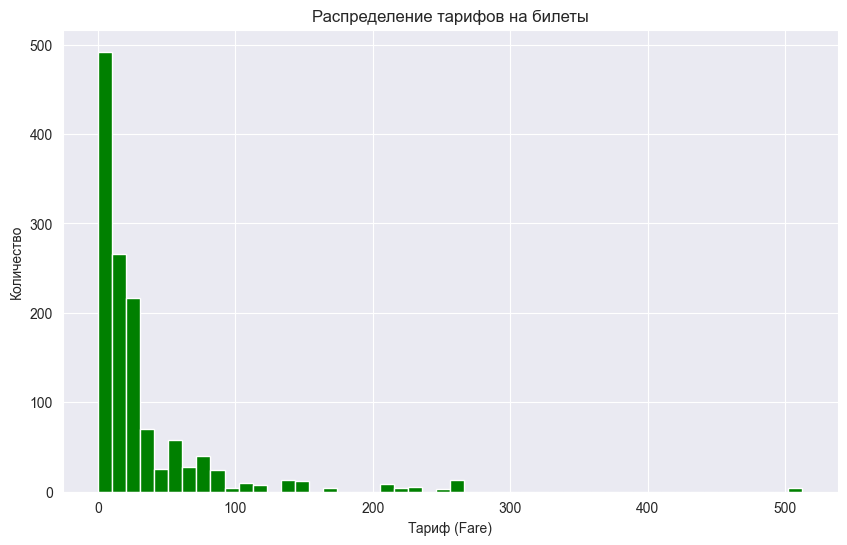


Подозрительные записи в 1-м классе (Fare < 20): 8 шт.
      PassengerId                                   Name  Fare  Ticket  \
263           264                  Harrison, Mr. William   0.0  112059   
633           634          Parr, Mr. William Henry Marsh   0.0  112052   
806           807                 Andrews, Mr. Thomas Jr   0.0  112050   
815           816                       Fry, Mr. Richard   0.0  112058   
822           823        Reuchlin, Jonkheer. John George   0.0   19972   
872           873               Carlsson, Mr. Frans Olof   5.0     695   
1157         1158  Chisholm, Mr. Roderick Robert Crispin   0.0  112051   
1263         1264                Ismay, Mr. Joseph Bruce   0.0  112058   

            Cabin  
263           B94  
633           NaN  
806           A36  
815          B102  
822           NaN  
872   B51 B53 B55  
1157          NaN  
1263  B52 B54 B56  


In [21]:
# 5. Анализ тарифов + поиск ошибок в 1-м классе
print("\nСтатистика по тарифам (Fare):")
print(full_data['Fare'].describe())

# График распределения тарифов
plt.figure(figsize=(10, 6))
full_data['Fare'].hist(bins=50, color='green')
plt.title('Распределение тарифов на билеты')
plt.xlabel('Тариф (Fare)')
plt.ylabel('Количество')
plt.show()

# Подозрительные записи в 1-м классе (Fare < 20 — очень низко для 1 класса)
suspicious = full_data[(full_data['Pclass'] == 1) & (full_data['Fare'] < 20)]
print(f"\nПодозрительные записи в 1-м классе (Fare < 20): {len(suspicious)} шт.")
print(suspicious[['PassengerId', 'Name', 'Fare', 'Ticket', 'Cabin']])

# Исправление групповых билетов: индивидуальный тариф
ticket_group_size = full_data.groupby('Ticket')['PassengerId'].transform('count')
full_data['Fare_Individual'] = full_data['Fare'] / ticket_group_size

In [22]:
# 6. Самые большие семьи
full_data['Family_Size'] = full_data['SibSp'] + full_data['Parch'] + 1
largest_families = full_data.sort_values('Family_Size', ascending=False).drop_duplicates('Ticket')

print("\n5 самых больших семей:")
print(largest_families[['Name', 'Family_Size', 'Survived', 'Ticket', 'SibSp', 'Parch']].head(5))


5 самых больших семей:
                                       Name  Family_Size  Survived    Ticket  \
1251            Sage, Master. William Henry           11         0  CA. 2343   
480          Goodwin, Master. Harold Victor            8         0   CA 2144   
182   Asplund, Master. Clarence Gustaf Hugo            7         0    347077   
119       Andersson, Miss. Ellis Anna Maria            7         0    347082   
68          Andersson, Miss. Erna Alexandra            7         1   3101281   

      SibSp  Parch  
1251      8      2  
480       5      2  
182       4      2  
119       4      2  
68        4      2  


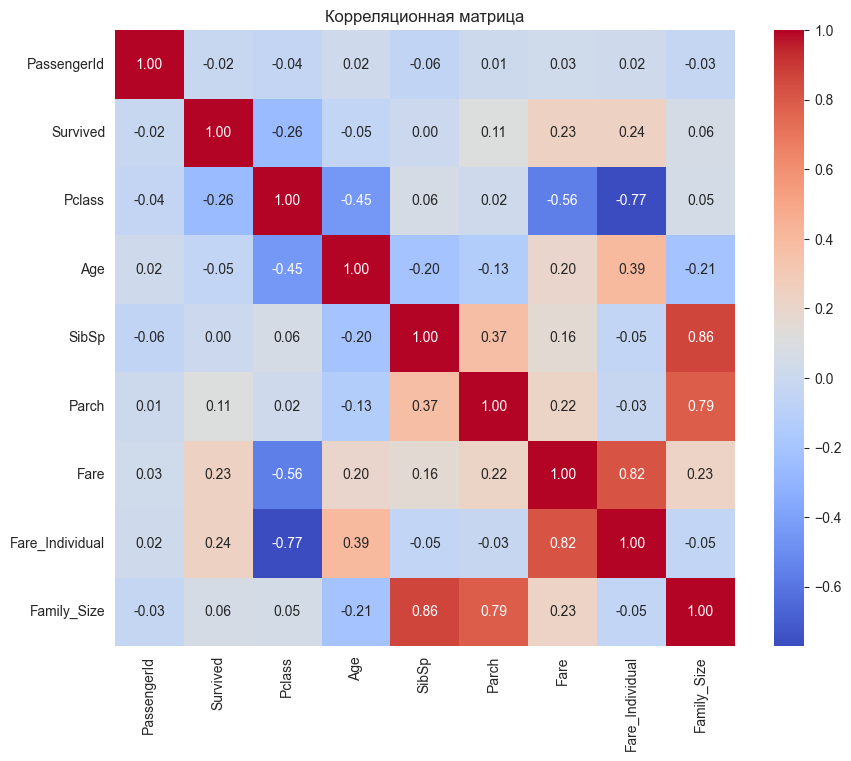


Основные выводы из корреляций:
- Survived сильно коррелирует с Fare (+) и Pclass (-)
- Pclass сильно отрицательно коррелирует с Fare


In [23]:
# 1. Корреляционная матрица и тепловая карта
numeric_cols = full_data.select_dtypes(include=['int64', 'float64'])
corr = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

print("\nОсновные выводы из корреляций:")
print("- Survived сильно коррелирует с Fare (+) и Pclass (-)")
print("- Pclass сильно отрицательно коррелирует с Fare")

In [24]:



# 2. Сводные таблицы по ключевым признакам
print("\nВыживаемость по полу:")
print(full_data.groupby('Sex')['Survived'].mean())

print("\nВыживаемость по классу:")
print(full_data.groupby('Pclass')['Survived'].mean())

print("\nВыживаемость по возрастной категории:")
print(full_data.groupby('Age_Cat')['Survived'].mean())

print("\nВыживаемость по размеру семьи:")
print(full_data.groupby('Family_Size')['Survived'].mean())



Выживаемость по полу:
Sex
female    0.82618
male      0.12930
Name: Survived, dtype: float64

Выживаемость по классу:
Pclass
1    0.575851
2    0.422383
3    0.269394
Name: Survived, dtype: float64

Выживаемость по возрастной категории:
Age_Cat
дети               0.487047
средний возраст    0.361034
старшие            0.272727
Name: Survived, dtype: float64

Выживаемость по размеру семьи:
Family_Size
1     0.292405
2     0.531915
3     0.559748
4     0.720930
5     0.227273
6     0.200000
7     0.312500
8     0.125000
11    0.181818
Name: Survived, dtype: float64


/var/folders/4c/jkygkw1s1yj6cx40mzszqyg00000gn/T/ipykernel_6617/2313917328.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(full_data.groupby('Age_Cat')['Survived'].mean())


In [25]:
# --------------------------------------------------
# Часть третья. Построение простых моделей
# --------------------------------------------------

# 1-2. Вероятностная модель (по Sex + Pclass)
prob_table = full_data.groupby(['Sex', 'Pclass'])['Survived'].mean().reset_index(name='Prob_Surv')

full_data = full_data.merge(prob_table, on=['Sex', 'Pclass'], how='left')

# Предсказание: если вероятность >= 0.5 → выжил
full_data['Model_Prob_Pred'] = (full_data['Prob_Surv'] >= 0.5).astype(int)

# 3. Модель на основе логических правил
def rule_based_survival(row):
    if row['Sex'] == 'female':
        return 1
    if row['Age'] < 18:
        return 1
    if row['Pclass'] == 1 and row['Sex'] == 'male':
        return 1  # мужчины 1 класса имели неплохие шансы
    return 0

full_data['Model_Rule_Pred'] = full_data.apply(rule_based_survival, axis=1)

# ------------------- ИСПРАВЛЕННАЯ ЧАСТЬ -------------------
# Определяем train_data ПОСЛЕ добавления всех новых колонок
train_data = full_data.iloc[:len(train)].copy()   # .copy() на всякий случай

# Оценка вероятностной модели на train-части
accuracy_prob = (train_data['Model_Prob_Pred'] == train_data['Survived']).mean()
print(f"\nAccuracy вероятностной модели (Sex + Pclass) на train: {accuracy_prob:.4f}")

# Оценка модели на логических правилах на train-части
accuracy_rule = (train_data['Model_Rule_Pred'] == train_data['Survived']).mean()
print(f"Accuracy модели на логических правилах на train: {accuracy_rule:.4f}")

# Дополнительно: можно посмотреть accuracy на всём датасете (для справки)
accuracy_prob_full = (full_data['Model_Prob_Pred'] == full_data['Survived']).mean()
accuracy_rule_full = (full_data['Model_Rule_Pred'] == full_data['Survived']).mean()
print(f"Accuracy вероятностной модели на полном датасете: {accuracy_prob_full:.4f}")
print(f"Accuracy модели на правилах на полном датасете: {accuracy_rule_full:.4f}")
# ---------------------------------------------------------



Accuracy вероятностной модели (Sex + Pclass) на train: 0.7868
Accuracy модели на логических правилах на train: 0.7329
Accuracy вероятностной модели на полном датасете: 0.8549
Accuracy модели на правилах на полном датасете: 0.7586


In [26]:

# Итог
print("\nВсе задачи выполнены!")
print("Новый датафрейм содержит колонки:")
print(full_data.columns.tolist())


Все задачи выполнены!
Новый датафрейм содержит колонки:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_Cat', 'Fare_Individual', 'Family_Size', 'Prob_Surv', 'Model_Prob_Pred', 'Model_Rule_Pred']


=== Анализ дополнительных признаков ===

1. Распределение по порту посадки (Embarked):
Embarked
S      914
C      270
Q      123
NaN      2
Name: count, dtype: int64

Выживаемость по порту посадки:
Embarked
C    0.492593
Q    0.439024
S    0.333698
Name: Survived, dtype: float64


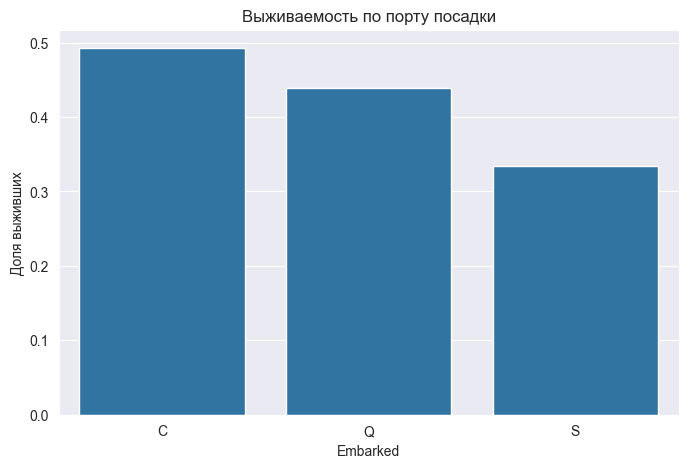


2. Выживаемость по наличию информации о каюте:
Has_Cabin
0    0.309665
1    0.610169
Name: Survived, dtype: float64


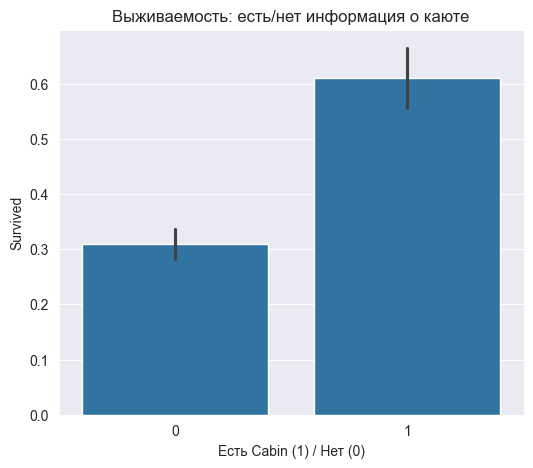


3. Распределение титулов:
Title
Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64

Выживаемость по титулам:
Title
Mrs       0.868687
Miss      0.791667
Master    0.377049
Rare      0.310345
Mr        0.107001
Name: Survived, dtype: float64


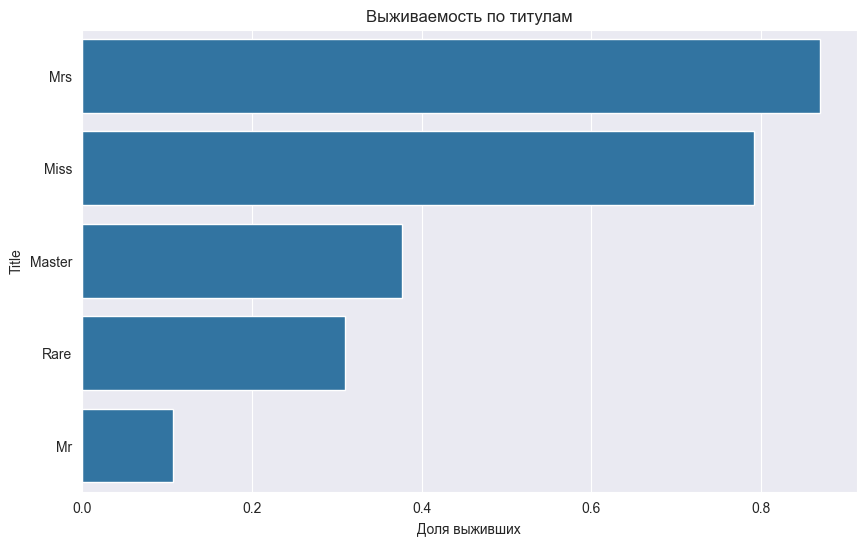


4. Выживаемость по категории семьи:
Family_Cat
Одинокий         0.292405
Малая семья      0.560641
Большая семья    0.219512
Name: Survived, dtype: float64


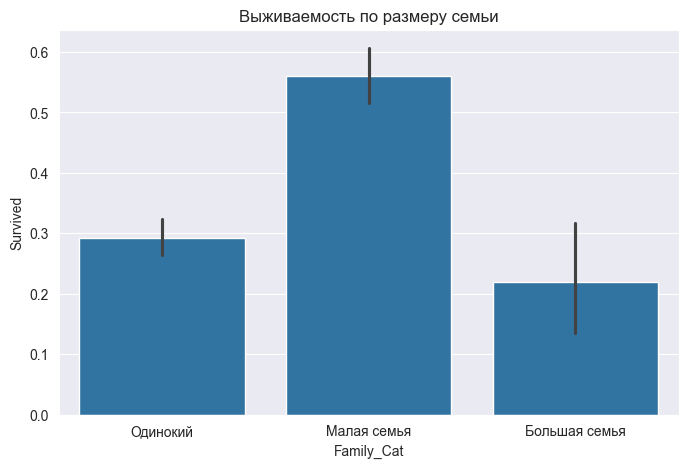


5. Выживаемость по полу и классу:
Pclass         1         2         3
Sex                                 
female  0.979167  0.943396  0.666667
male    0.251397  0.099415  0.095335

Выживаемость по титулу и классу:
Pclass         1         2         3
Title                               
Master  0.600000  0.818182  0.244444
Miss    0.967742  0.960784  0.662252
Mr      0.232704  0.053333  0.080357
Mrs     0.987179  0.927273  0.676923
Rare    0.473684  0.000000       NaN


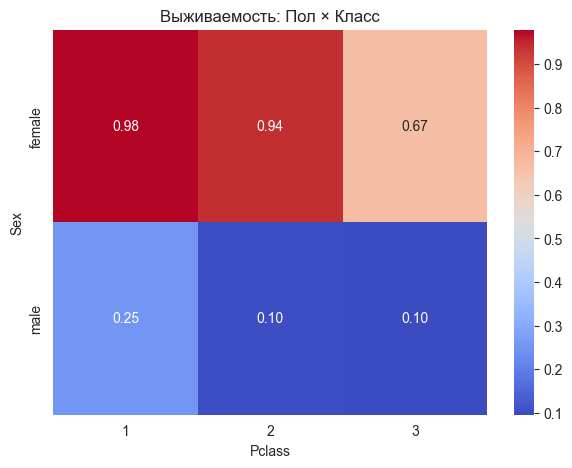


Готово! Добавлены колонки: Has_Cabin, Title, Family_Cat
Файл сохранён: full_titanic_extended.csv


In [28]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------
# Дополнение: Анализ других признаков Titanic
# --------------------------------------------------

# Предполагаем, что full_data уже создан в основном коде
# (если запускаете отдельно — раскомментируйте загрузку)
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# gender_submission = pd.read_csv('gender_submission.csv')
# test_merged = pd.merge(test, gender_submission, on='PassengerId', how='left')
# full_data = pd.concat([train, test_merged], ignore_index=True)

# Если Family_Size ещё нет — добавим
if 'Family_Size' not in full_data.columns:
    full_data['Family_Size'] = full_data['SibSp'] + full_data['Parch'] + 1

print("=== Анализ дополнительных признаков ===")

# 1. Embarked (порт посадки)
print("\n1. Распределение по порту посадки (Embarked):")
print(full_data['Embarked'].value_counts(dropna=False))

print("\nВыживаемость по порту посадки:")
embarked_survival = full_data.groupby('Embarked')['Survived'].mean()
print(embarked_survival)

# График
plt.figure(figsize=(8, 5))
sns.barplot(x=embarked_survival.index, y=embarked_survival.values)
plt.title('Выживаемость по порту посадки')
plt.ylabel('Доля выживших')
plt.show()

# 2. Наличие информации о каюте (Has_Cabin)
full_data['Has_Cabin'] = full_data['Cabin'].notna().astype(int)

print("\n2. Выживаемость по наличию информации о каюте:")
print(full_data.groupby('Has_Cabin')['Survived'].mean())

# График
plt.figure(figsize=(6, 5))
sns.barplot(x='Has_Cabin', y='Survived', data=full_data)
plt.title('Выживаемость: есть/нет информация о каюте')
plt.xlabel('Есть Cabin (1) / Нет (0)')
plt.show()

# 3. Извлечение титулов из имени (Title)
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return "NoTitle"

full_data['Title'] = full_data['Name'].apply(extract_title)

# Объединяем редкие титулы
full_data['Title'] = full_data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                'Jonkheer', 'Dona'], 'Rare')
full_data['Title'] = full_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
full_data['Title'] = full_data['Title'].replace('Mme', 'Mrs')

print("\n3. Распределение титулов:")
print(full_data['Title'].value_counts())

print("\nВыживаемость по титулам:")
title_survival = full_data.groupby('Title')['Survived'].mean().sort_values(ascending=False)
print(title_survival)

# График
plt.figure(figsize=(10, 6))
sns.barplot(x=title_survival.values, y=title_survival.index)
plt.title('Выживаемость по титулам')
plt.xlabel('Доля выживших')
plt.show()

# 4. Категоризация размера семьи
full_data['Family_Cat'] = pd.cut(full_data['Family_Size'],
                                 bins=[0, 1, 4, 11],
                                 labels=['Одинокий', 'Малая семья', 'Большая семья'],
                                 include_lowest=True)

print("\n4. Выживаемость по категории семьи:")
#print(full_data.groupby('Family_Cat')['Survived'].mean())
print(full_data.groupby('Family_Cat', observed=False)['Survived'].mean())

# График
plt.figure(figsize=(8, 5))
sns.barplot(x='Family_Cat', y='Survived', data=full_data)
plt.title('Выживаемость по размеру семьи')
plt.show()

# 5. Комбинированные закономерности
print("\n5. Выживаемость по полу и классу:")
print(full_data.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack())


print("\nВыживаемость по титулу и классу:")
print(full_data.groupby(['Title', 'Pclass'])['Survived'].mean().unstack())

# Тепловая карта Sex + Pclass
pivot = full_data.pivot_table(values='Survived', index='Sex', columns='Pclass', aggfunc='mean')
plt.figure(figsize=(7, 5))
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Выживаемость: Пол × Класс')
plt.show()

# Сохраняем расширенный датасет
full_data.to_csv('full_titanic_extended.csv', index=False)

print("\nГотово! Добавлены колонки: Has_Cabin, Title, Family_Cat")
print("Файл сохранён: full_titanic_extended.csv")